## ARIMA-GARCH to Model Volatality and Create Trading Strategy

The following code is an implementation of the [QuantStart ARIMA + GARCH Trading Strategy on the S&P500 Stock Market Index Using R](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R). 

### Importing Packages

In [3]:
# Importing Required Packages

library(quantmod)
library(lattice)
library(timeSeries)
library(rugarch)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: timeDate

Attaching package: ‘timeSeries’

The following object is masked from ‘package:zoo’:

    time<-

Loading required package: parallel

Attaching package: ‘rugarch’

The following object is masked from ‘package:stats’:

    sigma



### Importing the Dataset and Exploring its Values

In [8]:
# Importing the Dataset

getSymbols("^GSPC", from="2004-01-01")
spValues <- Cl(GSPC) # Save actual closing values in spValues
spReturns <- diff(log(Cl(GSPC))) # Save first-difference values of the logs of closing prices in spReturns
spReturns[as.character(head(index(Cl(GSPC)),1))] <- 0 # Set the first index to 0 

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Please see the Warning section of ‘?getSymbols.yahoo’ for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).


[1] "GSPC"

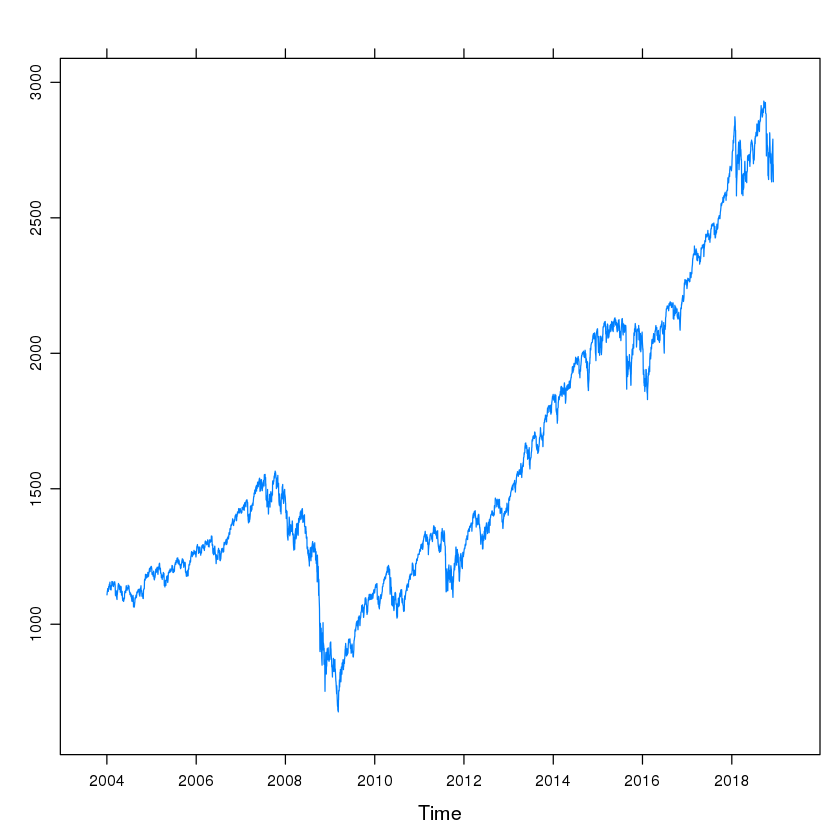

In [3]:
xyplot(spValues)

In [4]:
print(head(spValues))

           GSPC.Close
2004-01-02    1108.48
2004-01-05    1122.22
2004-01-06    1123.67
2004-01-07    1126.33
2004-01-08    1131.92
2004-01-09    1121.86


In [5]:
print(head(spReturns))

             GSPC.Close
2004-01-02  0.000000000
2004-01-05  0.012319151
2004-01-06  0.001291313
2004-01-07  0.002364367
2004-01-08  0.004950824
2004-01-09 -0.008927336


In [6]:
# Setting up the dimensions of the data structure containing forecast values 

windowLength <- 500
foreLength <- length(spReturns) - windowLength
returnForecasts <- vector(mode="character", length=foreLength)

### Modeling ARIMA, Using the Best ARIMA Parameters to Model GARCH and Make Predictions (takes awhile)

In [10]:
install.packages("svMisc")
library(svMisc)

for (d in 0:foreLength) { # Looping through every index in returnForecasts
  progress(d)
  spReturnsOffset = spReturns[(1+d):(windowLength+d)]
  
  final.aic <- Inf # setting the initial value of AIC (Akaike Information Critera) to infinity. This value will be used to tune the parameters of the ARIMA model; the lower the AIC value, the better the model is performing.
  final.order <- c(0,0,0)
  for (p in 0:5) for (q in 0:5) {
      if ( p == 0 && q == 0) {
    next # we can't have both p and q set to 0 while designing an ARIMA model
      }
  
  arimaFit <- tryCatch(arima(spReturnsOffset, order = c(p, 0, q)), # Try to fit the ARIMA(p,q) model to the given data of length 500
                       error = function(err) FALSE,  # Error Handling in R: if the arima function returns an error, save the value FALSE in arimaFit 
                       warning = function(err) FALSE) # Error Handling in R: if the arima function returns a warning, save the value FALSE in arimaFit 
  
  if (!is.logical(arimaFit)) { # if the result in arimaFit is not of logical TRUE or FALSE type  
    current.aic <- AIC(arimaFit) # set current.aic value to the value of ARIMA(p,q) AIC
    if (current.aic < final.aic) { # if this new current.aic is less than its previous value, update the model parameters
      final.aic <- current.aic
      final.order <- c(p, 0, q)
      final.arima <- arima(spReturnsOffset, order = final.order)
    }
  }
  else {
    next # if the result in arimaFit is of logical TRUE or FALSE type, try the next possible combination of p and q
    }
  }
                           
  # end of ARIMA p and q paramter tuning
                           
  # beginning of fitting the GARCH model
  
  spec <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)), # List containing the variance model specification: implements model = "sGARCH" by defualt 
    mean.model = list(armaOrder = c(final.order[1], final.order[3]), include.mean = T), # List containing the mean model specification
    distribution.model = "sged" # The conditional density to use for the innovations; “sged” is for the skew-generalized error distribution
  )
  
  fit <- tryCatch( # try to fit the specified model on spReturnsOffset
    ugarchfit(
      spec, spReturnsOffset, solver = "hybrid"
    ),
    error = function(e) e, # Error Handling in R: if the ugarchfit function returns an error, save the value e in fit 
    warning = function(w) w # Error Handling in R: if the ugarchfit function returns a warning, save the value w in fit 
  )
  
  if (is(fit, "warning")) { # if warning has been stored in fit
      # associate the value 1 with the date indexing the 500th element of spReturnsOffset
      # associate both these values with the 501th value (i.e. the forecast)
    returnForecasts[d+1] <- paste(index(spReturnsOffset[windowLength]), 1, sep = ",")  
    print(paste(index(spReturnsOffset[windowLength]), 1, sep = ","))
  }
  else { # if the GARCH model fitting is successful
    fore <- tryCatch({ugarchforecast(fit, n.ahead = 1)}, # try using the fitted model to make a prediction for the next one day
                      error = function(e) e)
    if ('error' %in% class(fore)){ # if the prediction process throws an error
      returnForecasts[d+1] = returnForecasts[d] # substitute the prediction to be made with previous day's prediction
      print('Error') # display 'Error' message at the step where the error occurred
    } else{
      ind <- fore@forecast[['seriesFor']] # save the forecasted volatality dataframe in ind
      # if the value at ind[1], which is the float associated with ind
      # is less than zero, then the value associated with the 500th index (date) in spReturnsOffset is set to -1
      # is greater than or equal to zero, then the value associated with the 500th index (date) in spReturnsOffset is set to 1
      # format: "date,1" at the d+1th index in returnForecasts 
      returnForecasts[d+1] = paste(colnames(ind), ifelse(ind[1] < 0, -1, 1), sep = ",") 
      print(paste(colnames(ind), ifelse(ind[1] < 0, -1, 1), sep = ","))  
    }
  }
  # saving the results into a CSV file
  write.csv(returnForecasts, file="../datasets/return_forecasts.csv", row.names=FALSE)
}

Installing package into ‘/user-home/1002/rstudio’
(as ‘lib’ is unspecified)

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



Progress:   0%  [1] "2005-12-23,1"
Progress:   1%  [1] "2005-12-27,1"
Progress:   2%  [1] "2005-12-28,-1"
Progress:   3%  [1] "2005-12-29,-1"
Progress:   4%  [1] "2005-12-30,1"
Progress:   5%  [1] "2006-01-03,-1"
Progress:   6%  [1] "2006-01-04,-1"
Progress:   7%  [1] "2006-01-05,1"
Progress:   8%  [1] "2006-01-06,-1"
Progress:   9%  [1] "2006-01-09,-1"
Progress:  10%  [1] "2006-01-10,1"
Progress:  11%  [1] "2006-01-11,-1"
Progress:  12%  [1] "2006-01-12,1"
Progress:  13%  [1] "2006-01-13,1"
Progress:  14%  [1] "2006-01-17,-1"
Progress:  15%  [1] "2006-01-18,1"
Progress:  16%  [1] "2006-01-19,-1"
Progress:  17%  [1] "2006-01-20,1"
Progress:  18%  [1] "2006-01-23,1"
Progress:  19%  [1] "2

### Python Refinement Script

**To be run separately in a Python environment** (Kernel > Change Kernel > Python 3.5)

In [1]:
forecasts = open("../datasets/return_forecasts.csv", "r").readlines()

old_value = 1
new_list = []
for f in forecasts[1:]:
    strpf = f.replace('"','').strip()
    new_str = "%s,%s\n" % (strpf, old_value)
    newspl = new_str.strip().split(",")
    if len(newspl) > 2:
        final_str = "%s,%s\n" % (newspl[0], newspl[2])
        final_str = final_str.replace('"','')
        old_value = f.strip().split(',')[1]
        new_list.append(final_str)

out = open("../datasets/return_forecasts_new.csv", "w")
for n in new_list:
    out.write(n)

**Switching back to R environment**

### Importing the Python-refined CSV File

In [4]:
# Input the Python-refined CSV file
spArimaGarch = as.xts( 
  read.zoo(
    file="../datasets/return_forecasts_new.csv", format="%Y-%m-%d", header=F, sep=","
  )
)

Warning message in zoo(rval3, ix):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”

In [5]:
print(head(spArimaGarch))

           [,1]
2005-12-23    1
2005-12-27    1
2005-12-28    1
2005-12-29   -1
2005-12-30   -1
2006-01-03    1


### Processing the GARCH Predictions 

In [9]:
library(svMisc)

# Create the ARIMA+GARCH returns
# The -1, 1 in the GARCH predictions are an estimate of volatality in the stock 
spIntersect = merge( spArimaGarch[,1], spReturns, all=F )
spArimaGarchReturns = spIntersect[,1] * spIntersect[,2]

In [10]:
print(head(spIntersect))

           spArimaGarch...1.    GSPC.Close
2005-12-23                 1  0.0004257673
2005-12-27                 1 -0.0095993091
2005-12-28                 1  0.0012963763
2005-12-29                -1 -0.0029849698
2005-12-30                -1 -0.0048987034
2006-01-03                 1  0.0162969645


In [11]:
print(head(spArimaGarchReturns))

           spArimaGarch...1.
2005-12-23      0.0004257673
2005-12-27     -0.0095993091
2005-12-28      0.0012963763
2005-12-29      0.0029849698
2005-12-30      0.0048987034
2006-01-03      0.0162969645


In [12]:
# Create the backtests for ARIMA+GARCH and Buy & Hold
# Backtesting is the process of testing a trading strategy on relevant historical data to ensure its viability 
spArimaGarchCurve = log(cumprod(1 + spArimaGarchReturns)) # calculating cumulative returns over the period of time by following the ARIMA-GARCH strategy
spBuyHoldCurve = log(cumprod(1 + spIntersect[,2]))  # calculating cumulative returns by following Buy and Hold Strategy
spCombinedCurve = merge(spArimaGarchCurve, spBuyHoldCurve, all=F)

In [13]:
print(head(spArimaGarchCurve))
print(head(spBuyHoldCurve))
print(head(spCombinedCurve))

           spArimaGarch...1.
2005-12-23      4.256767e-04
2005-12-27     -9.220003e-03
2005-12-28     -7.924466e-03
2005-12-29     -4.943942e-03
2005-12-30     -5.719862e-05
2006-01-03      1.610840e-02
              GSPC.Close
2005-12-23  0.0004256767
2005-12-27 -0.0092200028
2005-12-28 -0.0079244661
2005-12-29 -0.0109138998
2005-12-30 -0.0158246413
2006-01-03  0.0003409531
           spArimaGarch...1.    GSPC.Close
2005-12-23      4.256767e-04  0.0004256767
2005-12-27     -9.220003e-03 -0.0092200028
2005-12-28     -7.924466e-03 -0.0079244661
2005-12-29     -4.943942e-03 -0.0109138998
2005-12-30     -5.719862e-05 -0.0158246413
2006-01-03      1.610840e-02  0.0003409531


### Visualizing the Results 

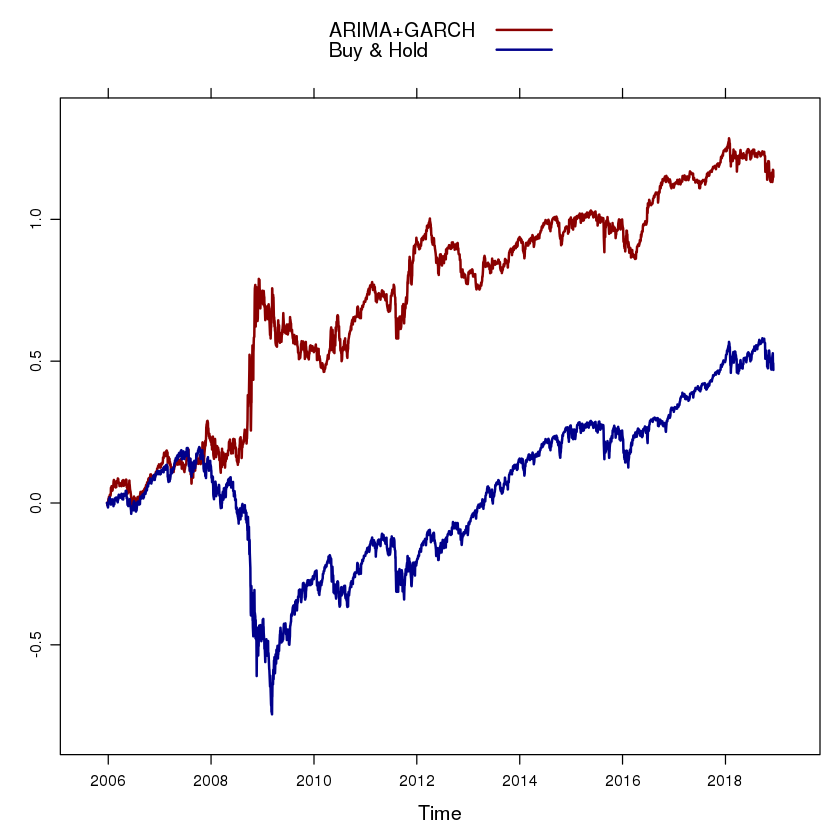

In [14]:
# Plot the equity curves
xyplot( 
  spCombinedCurve,
  superpose=T,
  col=c("darkred", "darkblue"),
  lwd=2,
  key=list( 
    text=list(
      c("ARIMA+GARCH", "Buy & Hold")
    ),
    lines=list(
      lwd=2, col=c("darkred", "darkblue")
    )
  )
)